# Preprocess Boom Data and its annotations


In [16]:
%load_ext autoreload
%autoreload 2

In [18]:
import pandas
import os
import pickle
from scipy.misc import imread
from os.path import join
import numpy as np
import itertools
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import math
import cv2

from utils.preprocess_data import *
from utils.process_dirs import *

## Uninoculated data

In [ ]:
txt_unin = '/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_1/ann_img.txt'

In [ ]:
samples_unin = read_paths(txt_unin)
print samples_unin[0].img_path

## Image example

In [ ]:
img = Image.open(samples_unin[0].img_path)
plt.imshow(img, cmap='Greys_r')

In [ ]:
for i, [ann_path, img_path] in enumerate(samples_unin):

    img_segments = extract_segmnets(ann_path)
    nmb_seg = count_lesions_nmb(img_segments)

    print "{}: {}, nmb_segments = {} \n"\
            .format(i, os.path.basename(img_path), len(img_segments))

### Drawn Overlay example

In [ ]:
f = 200
ann_path, img_path = samples_unin[f]

img_segments = extract_segmnets(ann_path)
nmb_lesions = count_lesions_nmb(img_segments)
if nmb_lesions == 0:
    print 'Number of lesions = 0'
else:
    for i, seg in enumerate(img_segments):
        print 'segment coordinates: {}, segment {} length: '.format(seg.coord(), i), seg.length()

    nmb_intersections = compute_intersections_nmb(img_segments)
    nmb_lesions = len(img_segments) - nmb_intersections
    print '\nnumber of intersections', nmb_intersections
    print "number of lesions {} \n".format(nmb_lesions)

fig, ax = plt.subplots(figsize=(60,20))
print img_path
img = Image.open(img_path)
draw = ImageDraw.Draw(img) 
if nmb_lesions:
    for seg in img_segments:
        draw.line(seg.coord(), fill=128, width = 10)
ax.imshow(img, cmap='Greys_r')

## Save images with overlaid segments and ellipses 

In [ ]:
import math

path_to_save = '/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_2/Imgs_masks/'

SAVE = True

for ann_path, img_path in samples_unin:

    basename = os.path.basename(img_path.split('.')[0])
    print basename
    img_segments = extract_segmnets(ann_path)
    nmb_lesions = count_lesions_nmb(img_segments)

    img = cv2.imread(img_path)
    
    if nmb_lesions:
        for seg in img_segments:
            x1,y1,x2,y2 = seg.coord()

            cv2.line(img, (x1,y1), (x2,y2), (0,0,255),5)
        if SAVE:
            cv2.imwrite(os.path.join(path_to_save,basename+'_line.JPG'),img)

    if nmb_lesions:
        for seg in img_segments:
            x1,y1,x2,y2 = seg.coord()

            center = (int((x1 + x2)*0.5), int((y1 + y2)*0.5))
            seglen = int(seg.length()/2)
            angle = int(math.atan2((y1-y2),(x1-x2))*180/math.pi)

            cv2.ellipse(img=img, center=center, axes=(seglen, seglen/4), angle=angle, startAngle=360, endAngle=0,  
                color=(0,0,255),thickness=-1)
        if SAVE:
            cv2.imwrite(os.path.join(path_to_save,basename+'_mask.JPG'),img)


## Create per pixel annotation with ellipse gt

In [ ]:
COEFF = 6 # ratio of ellipse axis
# Hlim = 180 # hue limit

path_to_save = '/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_1/Imgs_gtEllip/'
for i, (ann_path, img_path) in enumerate(samples_unin):
    basename = os.path.basename(img_path.split('.')[0])
    print basename
    img_segments = extract_segmnets(ann_path)

    img = cv2.imread(img_path)

    mask = np.ones(img.shape[:2], np.uint8)
    for seg in img_segments:

        x1,y1,x2,y2 = seg.coord()

        center = (int((x1 + x2)*0.5), int((y1 + y2)*0.5))
        seglen = int(seg.length()/2)
        angle = int(math.atan2((y1-y2),(x1-x2))*180/math.pi)

        cv2.ellipse(img=mask, center=center, axes=(seglen, seglen/COEFF), angle=angle, startAngle=360, endAngle=0,  
            color=255,thickness=-1)

    cv2.imwrite(os.path.join(path_to_save,basename+'_gtEllip.JPG'),mask)






## Split uninocul in quarters

In [ ]:
from utils.split_image_4_quarters import split_img_quarters

dir_to_save = '/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_1/Quarters/Imgs_gtEllip/'
imgs_dir = '/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_1/Imgs_gtEllip'

for i,img_path in enumerate(os.listdir(imgs_dir)):
    print i
    img_path = os.path.join(imgs_dir, img_path)
    split_img_quarters(img_path, dir_to_save)

In [ ]:
img = Image.open(dir_to_save+os.listdir(dir_to_save_save_save_saveto_save)[0])
plt.imshow(img, cmap='Greys_r')

## Create txt file with per pixel ann + quarter img paths

In [ ]:
ann_paths = np.sort(os.listdir('/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_2/Quarters/Imgs_gtEllip/'))
img_paths = os.listdir('/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_2/Quarters/Imgs/')

with open ('/home/anastasia/cropDL/data/boom/canopy_uninoculated_tyrwh_2/Quarters/ann_img_unin.txt', 'w') as txt:
    for ann_path in ann_paths:
        txt.write(ann_path+'\n')
    

### Show histogram

In [ ]:

# Calculate histogram with mask and without mask
# Check third argument for mask
img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
hist_full = cv2.calcHist([img],[0],None,[Hlim],[0,Hlim])
color = ('b','g','r')

fig, ax = plt.subplots(figsize=(20,5))
for i,col in enumerate(color):
    print col, i
    hist_mask = cv2.calcHist([img],[i],mask,[Hlim],[0,Hlim])
    ax.plot(hist_mask, color = col)
    ax.set_xlim([0,250])
    ax.grid()

plt.show()

### Extract lesion

In [ ]:
# define range of blue color in HSV
lower_lesion = np.array([140])
upper_lesion = np.array([179])


fig, ax = plt.subplots(figsize=(20,20))
# Threshold the HSV image to get only blue colors
masked_img_hls = cv2.cvtColor(masked_img, cv2.COLOR_BGR2HLS)
ax.imshow(masked_img_hls)
# crop lesion
# cropped = masked_img_hls[:2000:, 4000:]
# fig, ax = plt.subplots(figsize = (20,20))
# plt.imshow(cropped)
# cv2.imwrite('lesion.JPG', cropped)

masked_img_h = masked_img_hls[:,:,0]
ax.imshow(masked_img_h)
print masked_img_h.shape

mask_h = cv2.inRange(masked_img_h, lower_lesion, upper_lesion)

mask_hls = np.repeat(mask_h[:,:, np.newaxis], 3, axis = 2)

print 'mask_hls.dtype',mask_hls.dtype
print 'masked_img_hls.dtype', masked_img_hls.dtype
print mask_hls.shape, masked_img_hls.shape

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(mask_h)

# Bitwise-AND mask and original image
# res = cv2.bitwise_and(masked_img_hls,masked_img_hls, mask= mask_hls)


# print masked_img.shape
# fig, ax = plt.subplots(figsize = (20,20))
# plt.imshow(res)
# plt.imshow(masked_img_hls)

In [ ]:
nmb_lesions_uninoc = []
            
for ann_path,_ in samples_unin: 

    segments = extract_segmnets(ann_path)
    nmb_lesions_uninoc.append(count_lesions_nmb(segments))
    
print 'Mean number of lesions per uninoculated image is', np.mean(nmb_lesions_uninoc)

In [ ]:
f,a = plt.subplots(1,2, figsize=(15,5))
a = a.ravel()

a[0].hist(nmb_lesions_uninoc, facecolor='blue', bins = np.max(nmb_lesions_uninoc))
a[0].set_title('Histogram over nmb of lesions per image in TRAIN set')
a[0].set_xlabel('Nmb of lesions per image')
a[0].set_ylabel('Nmb of images')

# Inoculated data (more lesioned)

## Create file with segment annotation + image path

In [3]:
anns_inoc_dir_path = "/home/makarova/columbia/data/inoculated_tyr/Imgs_gtSeg/"
anns_inoc_dir_path = "/home/makarova/columbia/data/inoculated_tyr/Imgs/"
imgs_seg_inoc_dir_path = "/home/makarova/columbia/data/inoculated_tyr/Imgs_EllSeg/"

In [4]:
txt_inoc = "/home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_inoc.txt"

In [10]:
import os
import numpy as np
# create file with annotation paths
ann_paths = [os.path.join(anns_inoc_dir_path,f)\
             for f in os.listdir(anns_inoc_dir_path) if f.endswith('.JPG')]

with open (txt_inoc, 'w') as txt:
    for ann_path in np.sort(ann_paths):
        txt.write(ann_path+'\n')
        
# open file with vim and in opened console past:
# :%s/\(.*\)Count\(.*\)_results.csv/\1Count\2_results.csv\ \1Done\2.JPG/g
# then the paths to images will be added to the same line

['/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC04966_2.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC02243_3.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05454_1.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC03442_2.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05510_0.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC03251_1.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05660_3.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05830_0.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC06111_3.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05435_0.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05914_0.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC04893_0.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC03385_1.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05793_0.JPG', '/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC05557_0.

In [14]:
# check whether all image paths exist
with open (txt_inoc, 'r') as txt:
    lines = txt.readlines()
i = 0    
for line in lines:
    img_path = line.split(' ')[2].split('\n')[0]
    if os.path.isfile(img_path):
        pass
    else: 
        i+=1
        print line.split(' ')[2].split('\n')[0]
        
print i

0


## Create per ixel annotation

In [25]:
samples_inoc = read_paths(txt_inoc)
print samples_inoc[2].img_path
print samples_inoc[2]

/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC00975_1.JPG
Sample(ann_path='/home/makarova/columbia/data/inoculated_tyr/Imgs_gtSeg/DSC00975_1_gtSeg.JPG', img_path='/home/makarova/columbia/data/inoculated_tyr/Imgs/DSC00975_1.JPG')


## Image example

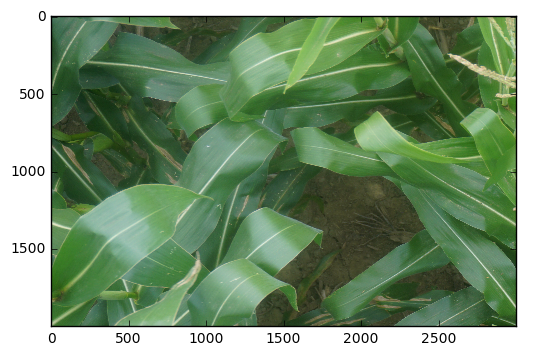

In [21]:
img = Image.open(samples_inoc[4].img_path)
plt.imshow(img, cmap='Greys_r')

In [23]:
nmb_seg_all = []
for i, [ann_path, img_path,_] in enumerate(samples_inoc):

    img_segments = extract_segmnets(ann_path)
    nmb_seg = count_lesions_nmb(img_segments)
    nmb_seg_all.append(nmb_seg)
    print "{}: {}, nmb_segments = {} \n"\
            .format(i, os.path.basename(img_path), len(img_segments))

ValueError: need more than 2 values to unpack

In [16]:
print 'Mean number of segments per image = {}'.format(np.mean(nmb_seg_all))

Mean number of segments per image = 8.66858457998


### Drawn Overlay example

segment coordinates: (1482, 580, 1666, 995), segment 0 length:  453.961452108
segment coordinates: (1663, 1178, 1830, 1547), segment 1 length:  405.030863022
segment coordinates: (2054, 218, 2121, 0), segment 2 length:  228.063587624
segment coordinates: (1539, 402, 1558, 235), segment 3 length:  168.07736314
segment coordinates: (205, 1507, 296, 1628), segment 4 length:  151.4001321
segment coordinates: (313, 1571, 243, 1485), segment 5 length:  110.887330205
segment coordinates: (275, 1439, 0, 1512), segment 6 length:  284.524164176
segment coordinates: (334, 1326, 0, 1442), segment 7 length:  353.570360749
segment coordinates: (2666, 1173, 3000, 1380), segment 8 length:  392.944016369
segment coordinates: (2709, 1143, 3000, 1353), segment 9 length:  358.860697207
segment coordinates: (2542, 1307, 3000, 1590), segment 10 length:  538.379977339
segment coordinates: (1720, 407, 1668, 558), segment 11 length:  159.702849067
segment coordinates: (1908, 113, 1954, 0), segment 12 length:  

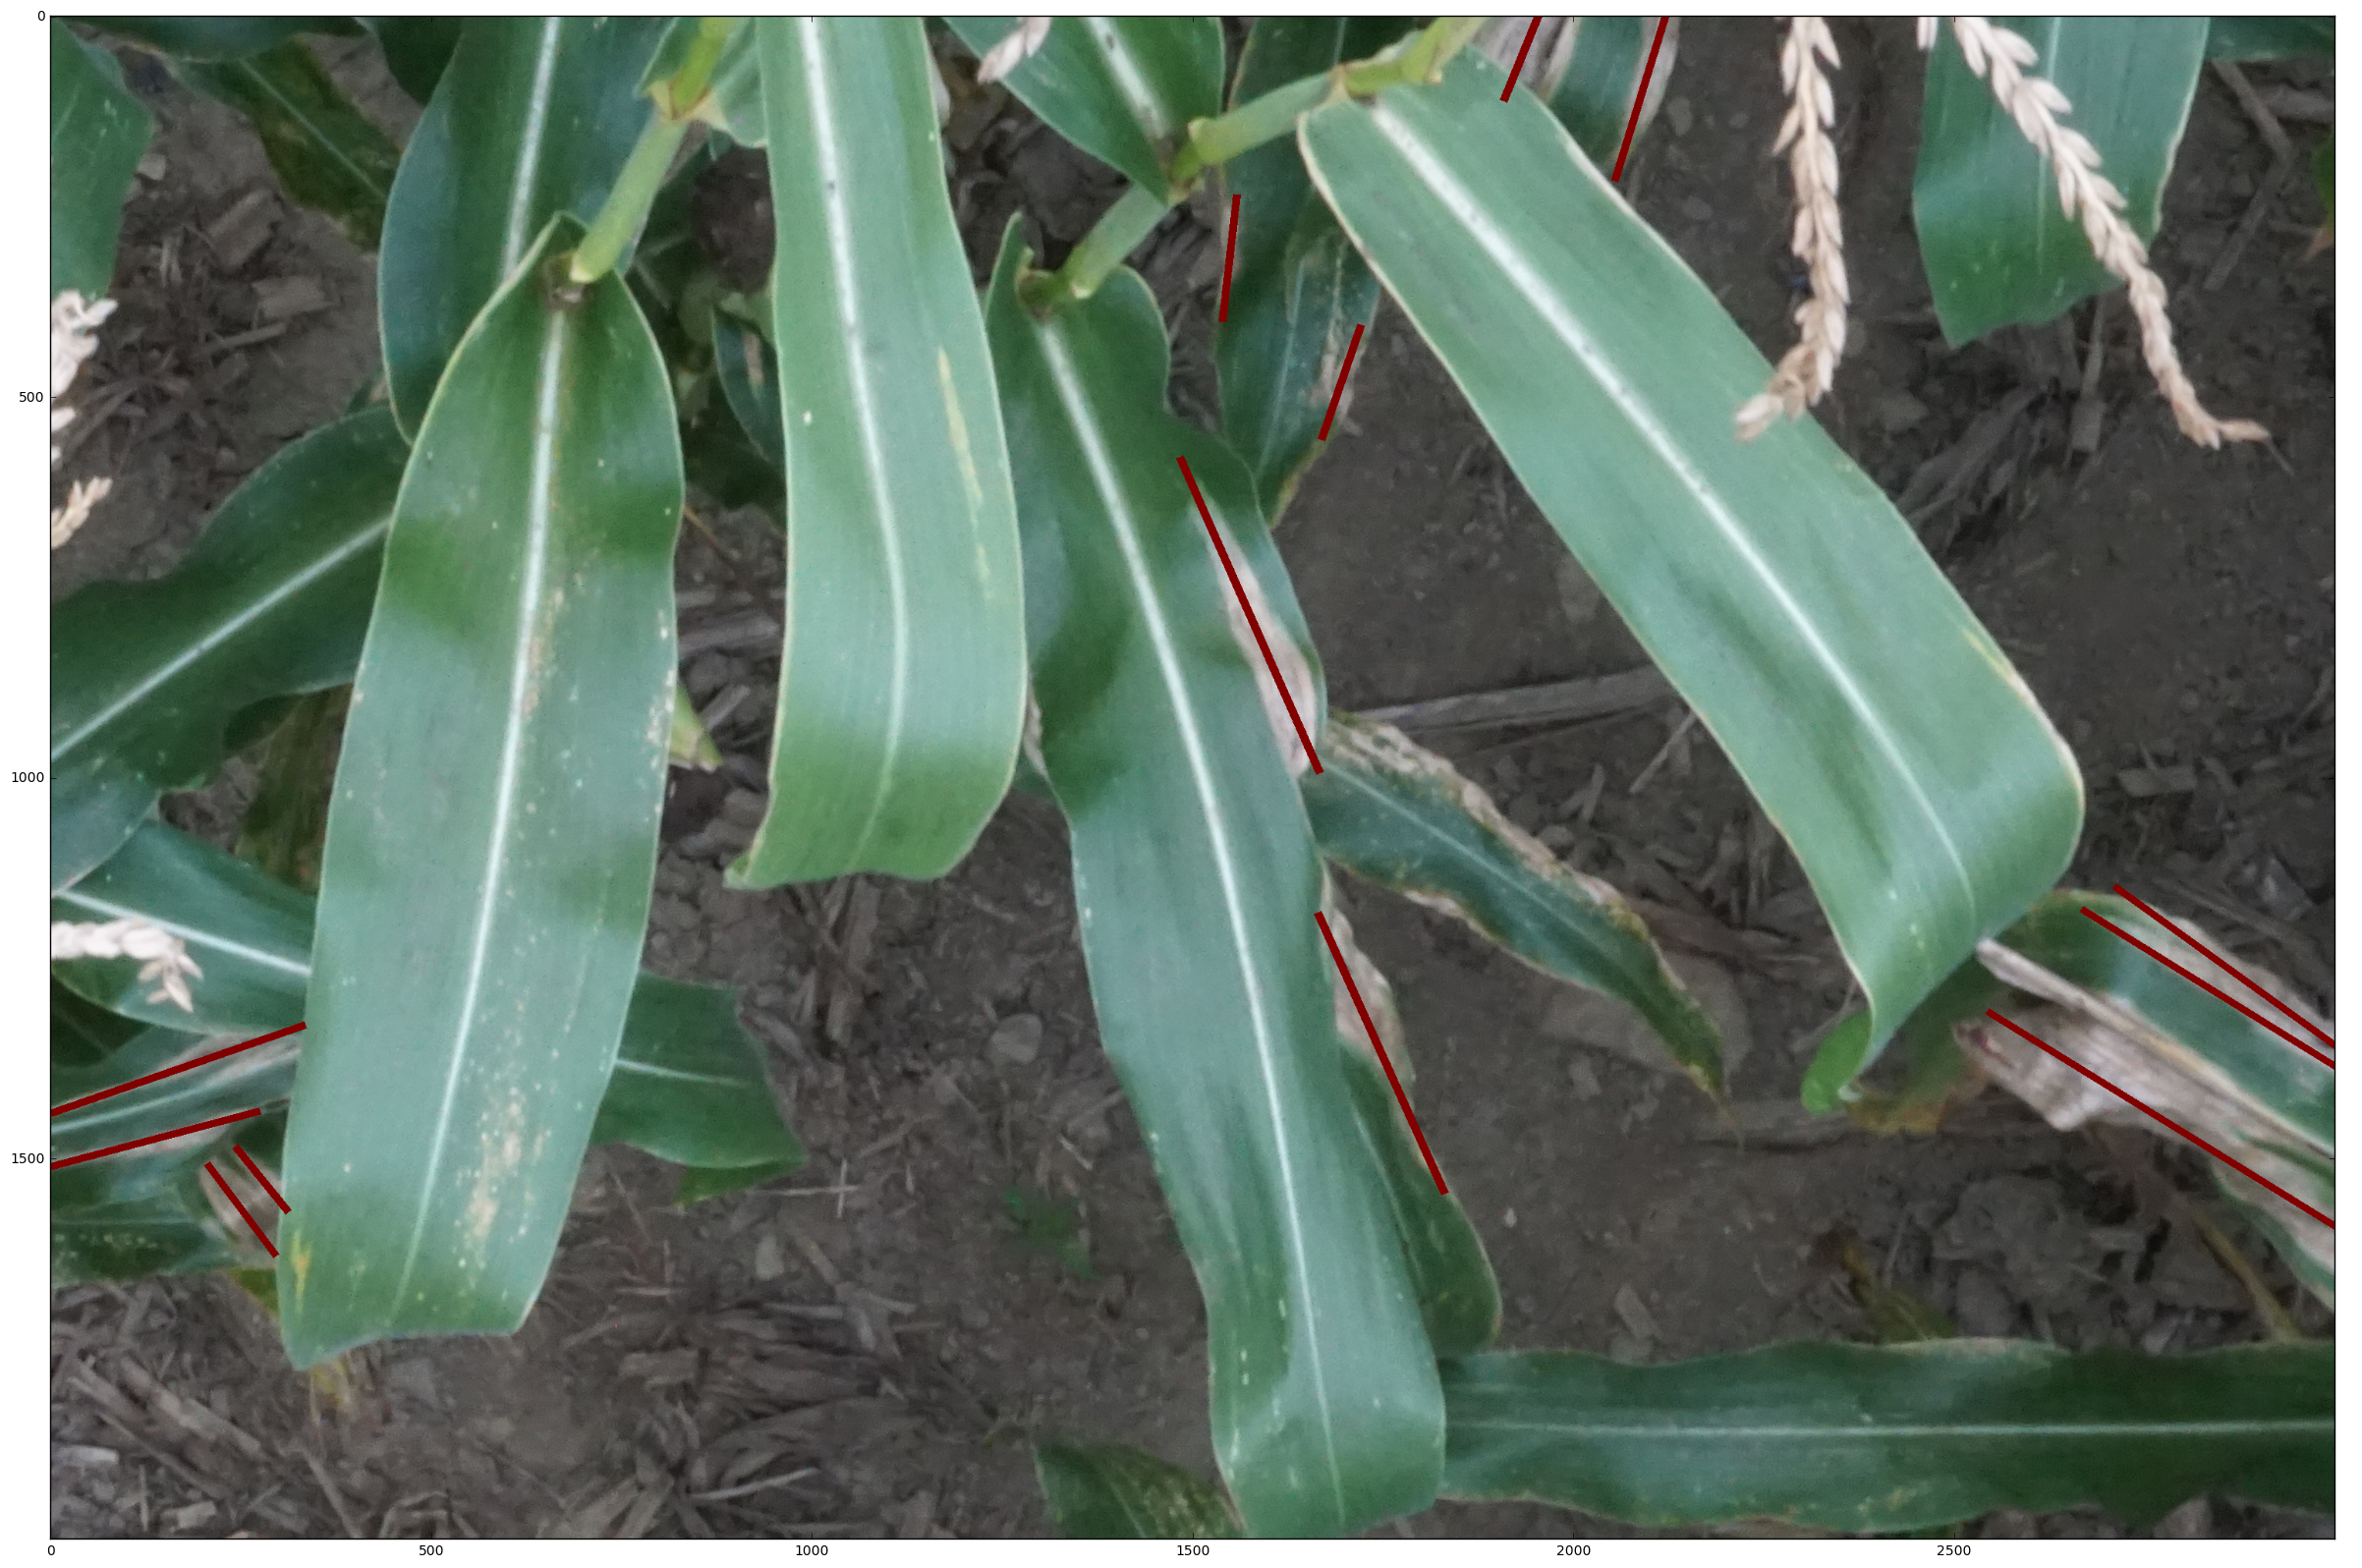

In [32]:
f = 25
ann_path, img_path = samples_inoc[f]

img_segments = extract_segmnets(ann_path)
nmb_lesions = count_lesions_nmb(img_segments)
if nmb_lesions == 0:
    print 'Number of lesions = 0'
else:
    for i, seg in enumerate(img_segments):
        print 'segment coordinates: {}, segment {} length: '.format(seg.coord(), i), seg.length()

    nmb_intersections = compute_intersections_nmb(img_segments)
    nmb_lesions = len(img_segments) - nmb_intersections
    print '\nnumber of intersections', nmb_intersections
    print "number of lesions {} \n".format(nmb_lesions)

fig, ax = plt.subplots(figsize=(60,20))
print img_path
img = Image.open(img_path)
draw = ImageDraw.Draw(img) 
if nmb_lesions:
    for seg in img_segments:
        draw.line(seg.coord(), fill=128, width = 10)
ax.imshow(img, cmap='Greys_r')

## Save images with overlaid segments and ellipses 

In [17]:
import math

path_to_save = '/home/makarova/columbia/data/inoculated_1/Imgs_masks/'

SAVE = True

for ann_path, img_path in samples_inoc:

    basename = os.path.basename(img_path.split('.')[0])
    print basename
    img_segments = extract_segmnets(ann_path)
    nmb_lesions = count_lesions_nmb(img_segments)

    img = cv2.imread(img_path)
    
    if nmb_lesions:
        for seg in img_segments:
            x1,y1,x2,y2 = seg.coord()

            cv2.line(img, (x1,y1), (x2,y2), (0,0,255),5)
        if SAVE:
            cv2.imwrite(os.path.join(path_to_save,basename+'_line.JPG'),img)

#     if nmb_lesions:
#         for seg in img_segments:
#             x1,y1,x2,y2 = seg.coord()

#             center = (int((x1 + x2)*0.5), int((y1 + y2)*0.5))
#             seglen = int(seg.length()/2)
#             angle = int(math.atan2((y1-y2),(x1-x2))*180/math.pi)

#             cv2.ellipse(img=img, center=center, axes=(seglen, seglen/4), angle=angle, startAngle=360, endAngle=0,  
#                 color=(0,0,255),thickness=-1)
#         if SAVE:
#             cv2.imwrite(os.path.join(path_to_save,basename+'_mask.JPG'),img)


DSC00971_0
DSC00975_0
DSC00975_1
DSC00976_1
DSC00982_0
DSC00982_3
DSC00985_2
DSC00990_0
DSC00990_2
DSC00991_1
DSC00992_1
DSC00997_0
DSC00999_0
DSC01003_0
DSC01005_3
DSC01012_1
DSC01974_2
DSC01975_3
DSC01980_1
DSC01981_3
DSC01991_1
DSC01993_2
DSC01994_0
DSC01994_3
DSC01996_2
DSC02004_1
DSC02006_2
DSC02007_0
DSC02007_1
DSC02010_2
DSC02014_0
DSC02018_2
DSC02023_1
DSC02030_3
DSC02031_1
DSC02034_2
DSC02037_3
DSC02041_1
DSC02053_3
DSC02054_0
DSC02055_1
DSC02057_0
DSC02059_0
DSC02060_2
DSC02062_1
DSC02064_1
DSC02071_3
DSC02073_2
DSC02077_0
DSC02088_0
DSC02090_3
DSC02091_0
DSC02102_3
DSC02103_0
DSC02111_1
DSC02112_1
DSC02113_1
DSC02114_1
DSC02118_2
DSC02121_3
DSC02126_0
DSC02127_2
DSC02136_1
DSC02139_0
DSC02139_3
DSC02144_0
DSC02146_1
DSC02152_1
DSC02154_2
DSC02154_3
DSC02155_0
DSC02155_2
DSC02156_0
DSC02156_2
DSC02157_0
DSC02157_1
DSC02158_1
DSC02158_3
DSC02159_1
DSC02159_2
DSC02160_0
DSC02160_1
DSC02161_0
DSC02161_1
DSC02162_0
DSC02162_1
DSC02163_1
DSC02163_2
DSC02164_0
DSC02164_1
DSC02165_2

## Create per pixel annotation with ellipse gt

In [47]:
COEFF = 6 # ratio of ellipse axis
# Hlim = 180 # hue limit

path_to_save = '/home/makarova/columbia/data/inoculated_1/Imgs_gtEllip/'
for i, (ann_path, img_path) in enumerate(samples_inoc):
    basename = os.path.basename(img_path.split('.')[0])
    print basename
    img_segments = extract_segmnets(ann_path)

    img = cv2.imread(img_path)

    mask = np.ones(img.shape[:2], np.uint8)
    for seg in img_segments:

        x1,y1,x2,y2 = seg.coord()

        center = (int((x1 + x2)*0.5), int((y1 + y2)*0.5))
        seglen = int(seg.length()/2)
        angle = int(math.atan2((y1-y2),(x1-x2))*180/math.pi)

        cv2.ellipse(img=mask, center=center, axes=(seglen, seglen/COEFF), angle=angle, startAngle=360, endAngle=0,  
            color=255,thickness=-1)

    cv2.imwrite(os.path.join(path_to_save,basename+'_gtEllip.JPG'),mask)






DSC02154_2


IOError: File /home/makarova/columbia/data/inoculated_3/Anns/DSC02154_2_results.csv does not exist

## Create txt file with per pixel ann + quarter img paths

In [52]:
ann_dir = '/home/makarova/columbia/data/inoculated_1/Imgs_gtEllip/'
ann_paths = np.sort(os.listdir(ann_dir))
img_paths = os.listdir('/home/makarova/columbia/data/inoculated_1/Imgs/')

txt_inoc = '/home/makarova/columbia/data/inoculated_1/gt_img_inoc.txt'
with open (txt_inoc, 'w') as txt:
    for ann_path in ann_paths:
        txt.write(os.path.join(ann_dir,ann_path+'\n'))
    

### Show histogram for hue in ellipse mask

In [ ]:

# # Calculate histogram with mask and without mask
# # Check third argument for mask
# img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
# hist_full = cv2.calcHist([img],[0],None,[Hlim],[0,Hlim])
# color = ('b','g','r')

# fig, ax = plt.subplots(figsize=(20,5))
# for i,col in enumerate(color):
#     print col, i
#     hist_mask = cv2.calcHist([img],[i],mask,[Hlim],[0,Hlim])
#     ax.plot(hist_mask, color = col)
#     ax.set_xlim([0,250])
#     ax.grid()

# plt.show()

# Merge several txt files and create train/valid/test txt

In [28]:
# txt files with paths to gt annotation and img
# txt1 = '/home/makarova/columbia/data/inoculated_ethan/gt_img_inoc.txt'
txt2 = '/home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_inoc.txt'

# txt_all = '/home/makarova/columbia/data/gt_img_inoc__tyrethan.txt'
txt_train = '/home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_train_inoc.txt'
txt_valid = '/home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_test_inoc.txt'
txt_test = '/home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_valid_inoc.txt'

In [ ]:
with open (txt2, 'r') as fin:
    lines1 = fin.readlines()
with open (txt1, 'r') as fin:
    lines2 = fin.readlines()

print 'len(lines1)', len(lines1)
lines1.extend(lines2) 
print 'len(lines1)', len(lines1) 

with open (txt_all, 'w') as fout:
    for i,line in enumerate(lines1):
        img_path = line.split(' ')[0]
        if os.path.isfile(img_path):
            fout.write(line)
        else: print i, line
    print i+1
        
        

In [29]:
import os

# with open (txt1, 'r') as fin:
#     lines1 = fin.readlines()
with open (txt2, 'r') as fin:
    lines2 = fin.readlines()
    
# print len(lines1), len(lines2)
print len(lines2)

# mode = 'w'
# print 'saved to:', txt_train, txt_valid, txt_test
# with open (txt_train, mode) as fout_train, open(txt_valid, mode) as fout_valid, open(txt_test, mode) as fout_test:
    
#     tr, v, ts = 0, 0, 0
#     for i,line in enumerate(lines1):
#         img_path = line.split(' ')[0]
#         if os.path.isfile(img_path):
#             if i < 400:
#                 fout_train.write(line)
#                 tr+=1
#             if 400 <= i < 450:
#                 fout_valid.write(line)
#                 v+=1
#             if i >= 450:
#                 fout_test.write(line)
#                 ts+=1
#     print tr, v, ts

mode = 'w'
print 'saved to:', txt_train, txt_valid, txt_test
with open (txt_train, mode) as fout_train, open(txt_valid, mode) as fout_valid, open(txt_test, mode) as fout_test:
    
    tr, v, ts = 0, 0, 0
    for i,line in enumerate(lines2):
        img_path = line.split(' ')[0]
        if os.path.isfile(img_path):
            if i < 3000:
                fout_train.write(line)
                tr+=1
            if 3000 <= i < 3200:
                fout_valid.write(line)
                v+=1
            if i >= 3200:
                fout_test.write(line)
                ts+=1
    print tr, v, ts

3476
saved to: /home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_train_inoc.txt /home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_test_inoc.txt /home/makarova/columbia/data/inoculated_tyr/txt/gtSeg_img_inoc/gtSeg_img_valid_inoc.txt
3000 200 276


# Crop images into smaller ones
Preprocess images